In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from konlpy.tag import Mecab
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
%matplotlib inline
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
train_target = train[['중식계', '석식계']]

In [4]:
train.loc[1142,'중식메뉴']

'쌀밥/ 곤드레밥/찰현미밥 된장찌개 돼지고추장불고기 버섯잡채 삼색물만두무침 겉절이김치/양념장 견과류샐러드*요거트D '

In [5]:
#### 띄어쓰기 및 오타 수정
train.at[1142, '중식메뉴'] = '쌀밥/곤드레밥/찰현미밥 된장찌개 돼지고추장불고기 버섯잡채 삼색물만두무침 겉절이김치/양념장 견과류샐러드*요거트D '
train['중식메뉴'] = train['중식메뉴'].str.replace('삽겹', '삼겹')

In [8]:
recipe1 = pd.read_csv('../input/레시피+기본정보_20210712.csv', encoding='cp949')
recipe2 = pd.read_csv('../input/레시피+재료정보_20210712.csv', encoding='cp949')

In [9]:
recipe1 = recipe1.iloc[:, :-2]

In [10]:
category = pd.read_excel('../input/대분류중분류.xlsx')

In [11]:
category

,대분류,중분류,소분류
0,밥류,쌀밥,눌은밥
1,밥류,쌀밥,쌀밥
2,밥류,쌀밥,찰밥
3,밥류,쌀밥,현미밥
4,밥류,잡곡밥류,잡곡밥(옥수수)
...,...,...,...
1265,원재료,채소류,당근
1266,원재료,채소류,깻잎
1267,원재료,채소류,깐마늘
1268,원재료,해조류,다시마(생것)


In [12]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        elif '/' in i:
            x_.extend(i.split('/'))
        elif '*' in i:
            x_.extend(i.split('*'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [13]:
train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [14]:
regex = "\(.*\)|\s-\s.*"
category['소분류'] = category['소분류'].apply(lambda x : re.sub(regex, '', x))

In [15]:
밥_list = list(category[category['대분류'] == '밥류']['소분류'])
과자빵_list = list(category[category['대분류'] == '과자 및 빵류']['소분류'])
면만두_list = list(category[category['대분류'] == '면 및 만두류']['소분류'])
죽_list = list(category[category['대분류'] == '죽류']['소분류'])
국_list = list(category[category['대분류'] == '국(탕)류']['소분류'])
찌개_list = list(category[category['대분류'] == '찌개류']['소분류'])
찜_list = list(category[category['대분류'] == '찜류']['소분류'])
구이_list = list(category[category['대분류'] == '구이류']['소분류'])
전_list = list(category[category['대분류'] == '전류']['소분류'])
볶음_list = list(category[category['대분류'] == '볶음류']['소분류'])
조림_list = list(category[category['대분류'] == '조림류']['소분류'])
튀김_list = list(category[category['대분류'] == '튀김류']['소분류'])
무침_list = list(category[category['대분류'] == '무침류']['소분류'])
김치_list = list(category[category['대분류'] == '김치류']['소분류'])
회_list = list(category[category['대분류'] == '회류']['소분류'])
젓갈_list = list(category[category['대분류'] == '젓갈류']['소분류'])
절임_list = list(category[category['대분류'] == '절임류']['소분류'])
장_list = list(category[category['대분류'] == '장류']['소분류'])
우유_list = list(category[category['대분류'] == '우유 및 유제품류']['소분류'])
음료_list = list(category[category['대분류'] == '음료류']['소분류'])
떡_list = list(category[category['대분류'] == '떡류']['소분류'])
원재료_list = list(category[category['대분류'] == '원재료']['소분류'])
주류_list = list(category[category['대분류'] == '주류']['소분류'])

In [16]:
num=[]
for t in range(train.shape[0]):
    for i in range(len(train['중식메뉴_split'][t])):
        token = train['중식메뉴_split'][t][i]
        if  token.endswith('주') or token in 주류_list:
            print(token)
            num.append(token)

In [17]:
num=pd.DataFrame(num)
num=pd.DataFrame(num.value_counts().index.values)
num=pd.DataFrame(num[0].apply(lambda x: x[0]))

In [18]:
num[0].values

array([], dtype=int64)

In [19]:
def get_Dae(data, col) :
    
    recipe_df = pd.DataFrame(np.zeros((data.shape[0], 25)), 
                          columns = ['밥류', '과자 및 빵류', '면 및 만두류', '죽류', '국(탕)류', '찌개류', '찜류', '구이류',
       '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '회류', '젓갈류', '절임류', '장류',
       '우유 및 유제품류', '음료류', '떡류', '원재료', '주류', '드레싱류', '조리_기타'])

    for t in range(data.shape[0]):
        for i in range(len(data[col][t])):
            token = data[col][t][i]
            if '덮밥' in token or '비빔밥' in token or '볶음밥' in token:
                recipe_df.at[t,'밥류'] +=3
            elif  token.endswith('밥') or '밥' in token or token in 밥_list:
                recipe_df.at[t, '밥류'] += 1 
                
            elif token.endswith('과자') or token in 과자빵_list:
                recipe_df.at[t, '과자 및 빵류'] += 3
                
            elif token.endswith('면') or token.endswith('만두') or '면' in token or '만두' in token or token in 면만두_list:
                recipe_df.at[t, '면 및 만두류'] += 4
                
            elif token.endswith('죽') or token in 죽_list or '죽' in token:
                recipe_df.at[t, '죽류'] += 2
                
            elif token.endswith('구이') or token in 구이_list or '구이' in token or token.endswith('데리야끼') or token.endswith('립') or\
                '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token:
                recipe_df.at[t, '구이류'] += 5
                
            elif token.endswith('국') or token.endswith('탕') or token in 국_list:
                if '만두' in token or '해물' in token or '도토리묵' in token or '냉국' in token or '사골' in token or '고기' in token or '해장' in token or token=='육개장'  or '수제비' in token or '옹심이' in token or '삼계탕' in token or '닭볶' in token or '전복' in token or '나주곰탕' in token or '감자탕' in token or '갈비' in token or '등뼈탕' in token or '들깨' in token or '홍합' in token or '새우' in token:
                    recipe_df.at[t, '국(탕)류'] += 4
                else:
                    recipe_df.at[t, '국(탕)류'] += 2
                    
            elif token.endswith('찌개') or token in 찌개_list:
                if '차돌' in token or '갈비' in token or '고기' in token or '돼지' in token: 
                    recipe_df.at[t, '찌개류'] += 4
                else:
                    recipe_df.at[t, '찌개류'] += 2
                
            elif token.endswith('찜') or token in 찜_list or '찜' in token or '보쌈' in token or '수육' in token or '김치말이' in token:
                if '브로컬리들깨찜' in token or  '꽈리고추찜' in token or  '깻잎찜' in token or  '가지찜' in token or  '청경채찜' in token or '호박잎쌈' in token:
                    recipe_df.at[t, '찜류'] += 2
                else:
                    recipe_df.at[t, '찜류'] += 4
                
            elif token.endswith('전') or token in 전_list or '전병' in token:
                recipe_df.at[t, '전류'] += 3
                
            elif token.endswith('볶음') or token in 볶음_list or '볶음' in token or token == '깐풍연근' or \
                '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token:
                if '미역줄기볶음' in token or '마늘쫑볶음' in token or '카레감자채볶음' in token or '모둠버섯볶음' in token or '고구마순볶음' in token or '콩나물볶음' in token or '버섯볶음' in token or '멸치' in token or '가지볶음' in token or '애기새송이버섯볶음' in token or '파프리카감자채볶음' in token or '호박새우젓볶음' in token or '청경채새송이볶음' in token or '오이볶음' in token or '호박채나물볶음' in token or '도라지볶음' in token or '도라지나물볶음' in token or '고춧잎볶음' in token or '고구마줄기볶음' in token or '감자볶음' in token or '새송이버섯볶음' in token or '가지볶음' in token or '브로콜리버섯볶음' in token or '명엽채볶음' in token or '매운호박볶음' in token or '머위대들깨볶음' in token or '멸치볶음' in token:
                    recipe_df.at[t, '볶음류'] += 1
                else:
                    recipe_df.at[t, '볶음류'] += 3
                
            elif token.endswith('조림') or token in 조림_list or '조림' in token or '오향장육' in token or '동파육' in token:
                if '땅콩조림' in token or '연근조림' in token or '견과류조림' in token or '연근땅콩조림' in token or '새송이버섯조림' in token or '우엉조림' in token or '시래기조림' in token or '검정콩조림' in token or '꽈리고추어묵조림' in token or '단호박장조림' in token or '감자조림' in token or '견과류연근조림' in token or '고추장감자조림' in token or '꽈리고추감자조림' in token or '콩조림' in token:
                    recipe_df.at[t, '조림류'] += 1
                else:
                    recipe_df.at[t, '조림류'] += 3
            elif token.endswith('튀김') or token.endswith('치킨') or token.endswith('탕수육') or '치킨' in token or '탕수' in token or token in 튀김_list or\
                '튀김' in token or '통닭' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or\
                token.endswith('고로케') or '유린기' in token or '탕수' in token or token.endswith('닭') or '너겟' in token or\
                token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token:
                recipe_df.at[t, '튀김류'] += 5
                
            elif token.endswith('무침') or token in 무침_list or '무침' in token or '파채' in token or token.endswith('샐러드') or '양장피' in token\
            or '범벅' in token or token.endswith('채'):
                recipe_df.at[t, '무침류'] += 1
                
            elif token.endswith('김치') or token in 김치_list or '겉절이' in token:
                recipe_df.at[t, '김치류'] += 1
                
            elif token.endswith('회') or token in 회_list:
                recipe_df.at[t, '회류'] += 1
                
            elif token.endswith('젓갈') or token in 젓갈_list or '젓갈' in token:
                recipe_df.at[t, '젓갈류'] += 1
                
            elif token.endswith('절임') or token in 절임_list or '절임' in token:
                recipe_df.at[t, '절임류'] += 1
                
            elif token.endswith('장') or token in 장_list:
                recipe_df.at[t, '장류'] += 1
                
            elif token.endswith('우유') or token in 우유_list:
                recipe_df.at[t, '우유 및 유제품류'] += 1
                
            elif token.endswith('음료') or token in 음료_list or '요구르트' in token:
                recipe_df.at[t, '음료류'] += 1
                
            elif token.endswith('떡') or token in 떡_list:
                recipe_df.at[t, '떡류'] += 2
                
            elif token in 원재료_list or token == '연두부' or token.endswith('김') or '생' in token or token.endswith('쌈'):
                recipe_df.at[t, '원재료'] += 1
                
            elif token.endswith('주') or token in 주류_list:
                recipe_df.at[t, '주류'] += 1
                
            elif token.endswith('드레싱') or 'D' in token or '소스' in token:
                recipe_df.at[t, '드레싱류'] += 1
                
            else :
                recipe_df.at[t, '조리_기타'] += 1
            
    return recipe_df

In [20]:
train_중식=get_Dae(train, '중식메뉴_split')
train_석식=get_Dae(train, '석식메뉴_split')

In [21]:
test_중식=get_Dae(test, '중식메뉴_split')
test_석식=get_Dae(test, '석식메뉴_split')

In [22]:
train_중식['중식점수']=train_중식.sum(axis=1)
train_석식['석식점수']=train_석식.sum(axis=1)
test_중식['중식점수']=test_중식.sum(axis=1)
test_석식['석식점수']=test_석식.sum(axis=1)

### 1. 요일,일자 변환

In [65]:
def transform_day_to_num(x) :
    if x == '월' :
        return 5
    elif x == '화' :
        return 4
    elif x == '수' :
        return 3
    elif x == '목' :
        return 2
    else :
        return 1        

In [66]:
train['요일'] = train['요일'].apply(transform_day_to_num)
test['요일'] = test['요일'].apply(transform_day_to_num)

***

In [67]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

In [68]:
train['년'] = train['일자'].dt.year
test['년'] = test['일자'].dt.year

In [69]:
train['월'] = train['일자'].dt.month
test['월'] = test['일자'].dt.month

In [70]:
train['일'] = train.일자.dt.day
test['일'] = test.일자.dt.day

In [71]:
train['주'] = train.일자.dt.week
test['주'] = test.일자.dt.week

In [72]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '중식메뉴_split',
       '석식메뉴_split', '년', '월', '일', '주'],
      dtype='object')

In [123]:
train_점심=pd.concat([train[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수','년','월','주']],train_중식],axis=1)
test_점심=pd.concat([test[['요일','본사정원수','본사시간외근무명령서승인건수','현본사소속재택근무자수','년','월','주']],test_중식],axis=1)
train_저녁 = pd.concat([train[['요일','본사정원수','본사휴가자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','년','월','주']],train_석식],axis=1)
test_저녁 = pd.concat([test[['요일','본사정원수','본사휴가자수','본사시간외근무명령서승인건수','현본사소속재택근무자수','년','월','주']],test_석식],axis=1)

In [124]:
X1 = train_점심
y1 = train.중식계
target1 = test_점심

In [125]:
X2 = train_저녁
y2 = train.석식계
target2 = test_저녁

In [126]:
from lightgbm import LGBMRegressor
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score
import random

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:32<00:00,  2.89it/s]

(97, -90.03758959029744)


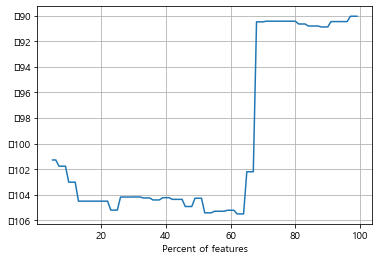

In [127]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X1, y1)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y1, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [128]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X1, y1)
X1_select = fs.transform(X1)
target1_select = fs.transform(target1)

In [129]:
print(X1_select.shape)
print(X1.columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 31)
['요일', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '년', '월', '주', '밥류', '과자 및 빵류', '면 및 만두류', '죽류', '국(탕)류', '찌개류', '찜류', '구이류', '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '회류', '젓갈류', '절임류', '장류', '우유 및 유제품류', '음료류', '떡류', '원재료', '드레싱류', '조리_기타', '중식점수']


In [130]:
X1 = train_점심[['요일', '본사정원수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '년', '월', '주', '밥류', '면 및 만두류', '국(탕)류', '찌개류', '전류', '볶음류', '무침류', '김치류', '회류', '젓갈류', '절임류', '우유 및 유제품류', '음료류', '원재료', '드레싱류', '조리_기타', '중식점수']]
y1 = train.중식계
target1 = test_점심[X1.columns]

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:31<00:00,  3.03it/s]

(55, -61.57700805321004)


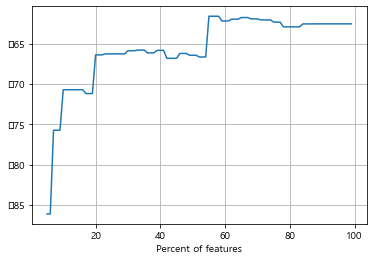

In [131]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X2, y2)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y2, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [132]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X2, y2)
X2_select = fs.transform(X2)
target2_select = fs.transform(target2)

In [133]:
print(X2_select.shape)
print(X2.columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 18)
['요일', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '년', '주', '밥류', '국(탕)류', '찜류', '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '장류', '우유 및 유제품류', '떡류', '석식점수']


In [134]:
X2 = train_저녁[['요일', '본사정원수', '본사휴가자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '년', '월', '주', '밥류', '국(탕)류', '찌개류', '찜류', '구이류', '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '장류', '우유 및 유제품류', '떡류', '원재료', '드레싱류', '조리_기타', '석식점수']]
y2 = train.석식계
target2 = test_저녁[X2.columns]

***

In [135]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor

LGBM만 사용하면 PB : 71

In [136]:
kf = KFold(n_splits = 15, random_state = 607, shuffle = True)

In [137]:
lgbm = LGBMRegressor(random_state = 607, max_depth = 4, n_estimators = 20000, learning_rate = .01)

In [138]:
lgbm_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = lgbm.predict(target1) / 15
    lgbm_pred_1 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 50.298	training's l2: 4653.49	valid_1's l1: 76.3394	valid_1's l2: 12201.2
Early stopping, best iteration is:
[406]	training's l1: 68.3166	training's l2: 8527.32	valid_1's l1: 71.2654	valid_1's l2: 10579
FOLD MAE = 71.26544811666997
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 50.3163	training's l2: 4719.76	valid_1's l1: 64.2434	valid_1's l2: 7130.96
Early stopping, best iteration is:
[1171]	training's l1: 55.7574	training's l2: 5892.12	valid_1's l1: 64.7831	valid_1's l2: 6874.38
FOLD MAE = 64.78311752245787
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 48.1757	training's l2: 4172.36	valid_1's l1: 91.5305	valid_1's l2: 19078.4
Early stopping, best iteration is:
[1027]	training's l1: 55.146	training's l2: 5507.56	valid_1's l1: 90.9945	valid_1's l2: 18367.1
FOLD MAE = 90.9945022778894
Training until validation scores don't impr

In [139]:
lgbm_pred_1.sum()

49175.20451986684

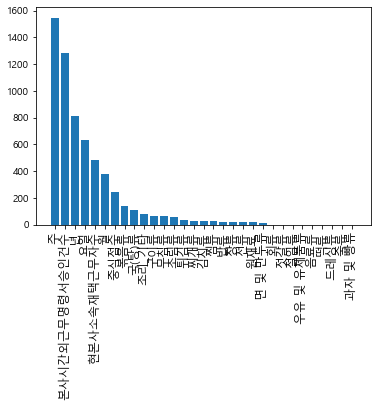

In [140]:
a=pd.DataFrame(data=lgbm.feature_importances_,index=X1.columns)
a=a.sort_values(by=0,ascending=False)
a.columns=['value']

plt.bar(a.index, a.value)
plt.xticks(fontsize=12, rotation='vertical') 
plt.show()

In [141]:
lgbm_pred_2 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    print(f'FOLD MAE = {mae}')
    mae_list.append(mae)
    sub_pred = lgbm.predict(target2) / 15
    lgbm_pred_2 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 32.6902	training's l2: 2193.67	valid_1's l1: 49.5936	valid_1's l2: 4609.11
[4000]	training's l1: 29.7014	training's l2: 1783.27	valid_1's l1: 50.6	valid_1's l2: 4653.95
Early stopping, best iteration is:
[2514]	training's l1: 31.5046	training's l2: 2028.95	valid_1's l1: 49.3619	valid_1's l2: 4576.46
FOLD MAE = 49.361939419585596
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 32.4749	training's l2: 1982.2	valid_1's l1: 57.2427	valid_1's l2: 9086.38
Early stopping, best iteration is:
[524]	training's l1: 42.0765	training's l2: 3470.19	valid_1's l1: 57.2947	valid_1's l2: 8480.68
FOLD MAE = 57.2946671604964
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 32.0647	training's l2: 2003.39	valid_1's l1: 58.5204	valid_1's l2: 6804.74
Early stopping, best iteration is:
[770]	training's l1: 39.9278	training's l2: 3137.77	valid_1's l1: 57.65

In [142]:
lgbm_pred_2.sum()

25104.767144082623

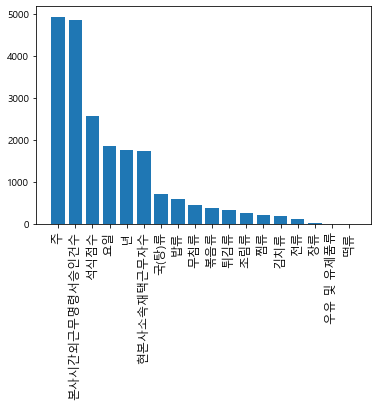

In [143]:
a=pd.DataFrame(data=lgbm.feature_importances_,index=X2.columns)
a=a.sort_values(by=0,ascending=False)
a.columns=['value']

plt.bar(a.index, a.value)
plt.xticks(fontsize=12, rotation='vertical') 
plt.show()

In [144]:
submission['중식계'] = lgbm_pred_1
submission['석식계'] = lgbm_pred_2

In [145]:
submission

,일자,중식계,석식계
0,2021-01-27,995.805901,366.860338
1,2021-01-28,898.965154,412.183357
2,2021-01-29,698.283129,313.989280
3,2021-02-01,1257.362192,511.256259
4,2021-02-02,1004.411146,453.577883
5,2021-02-03,993.283858,391.713839
6,2021-02-04,983.505945,428.973926
7,2021-02-05,718.486869,332.108331
8,2021-02-08,1240.674395,641.188158
9,2021-02-09,1020.352058,546.319228


In [146]:
submission.to_csv('lgbm_08.csv', index = False)

In [147]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

In [148]:
ngb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target1) / 15
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 74.95736605768688
FOLD MAE = 46.34113590125236
FOLD MAE = 58.0221758067129
FOLD MAE = 46.037638026444846
FOLD MAE = 40.5907728755781
FOLD MAE = 43.95906916028516
FOLD MAE = 37.52917807153682
FOLD MAE = 46.27340910976486
FOLD MAE = 39.01583791065816
FOLD MAE = 41.115881395081836
FOLD MAE = 50.0299753857786
FOLD MAE = 31.860356822502048
FOLD MAE = 33.30843152181201
FOLD MAE = 37.253296020732
FOLD MAE = 32.78622653199786

NGBRegressor MAE = 43.93871670652163


In [149]:
ngb_pred_1.sum()

51111.26655508483

In [150]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

In [151]:
ngb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target2) / 15
    ngb_pred_2 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 49.45853195753588
FOLD MAE = 35.46510822927462
FOLD MAE = 37.746490294872316
FOLD MAE = 31.35850519843692
FOLD MAE = 30.829273710979887
FOLD MAE = 28.619268152390113
FOLD MAE = 33.179206292214616
FOLD MAE = 28.202798519521856
FOLD MAE = 35.08411899071176
FOLD MAE = 34.547440164894965
FOLD MAE = 25.703716689508166
FOLD MAE = 28.045931069510583
FOLD MAE = 26.907000585666502
FOLD MAE = 32.383274053599045
FOLD MAE = 24.305057260744764

NGBRegressor MAE = 32.122381411324135


In [152]:
ngb_pred_2.sum()

25796.55183964585

In [153]:
submission['중식계'] = ngb_pred_1
submission['석식계'] = ngb_pred_2

In [154]:
submission.to_csv('nbg_08.csv', index = False)

In [155]:
nbg=pd.read_csv('nbg_08.csv')

In [156]:
lgbm=pd.read_csv('lgbm_08.csv')

In [157]:
ensemble=nbg.copy()

In [158]:
ensemble['중식계']=nbg['중식계']*0.5+lgbm['중식계']*0.5

In [159]:
ensemble['석식계']=nbg['석식계']*0.5+lgbm['석식계']*0.5

### 49482.43247838575, 24917.37723101190

In [162]:
ensemble.중식계.sum()

50143.23553747585

In [163]:
ensemble.석식계.sum()

25450.659491864233

In [164]:
ensemble.head()

,일자,중식계,석식계
0,2021-01-27,1018.259510,351.944346
1,2021-01-28,898.995773,440.261609
2,2021-01-29,735.252037,307.369317
3,2021-02-01,1292.675368,533.207795
4,2021-02-02,1022.464538,478.329521


In [168]:
ensemble.to_csv('ensemble_09.csv', index = False)

In [165]:
ensemble_08=pd.read_csv('ensemble_08.csv')

In [118]:
ensemble_07=pd.read_csv('ensemble_07.csv')

In [119]:
import scipy.stats

In [166]:
scipy.stats.pearsonr(ensemble_07['중식계'], ensemble_08['중식계'])

(0.9940864155219648, 6.022886130875817e-48)

In [167]:
scipy.stats.pearsonr(ensemble_07['석식계'], ensemble_08['석식계'])

(0.9704123195013201, 2.802838179450932e-31)